## Integer representations

Integers are typically represented in binary as a base-2 bit pattern, and in python the built-in function `bin` can be used to inspect that:

In [1]:
bin(19)

'0b10011'

If the number of bits used is fixed, the range of integers that can be represented would be fixed and can potentially overflow. That is the case for many languages such as C/C++.

In python, integers have arbitrary precision http://stackoverflow.com/questions/4581842/python-integer-ranges and therefore we can represent an arbitrary large range of integers (only limited by memory available). 

In [2]:
2 ** 200

1606938044258990275541962092341162602522202993782792835301376

However as I'll explain in this post, one still needs to be careful with precision issues especially when using the pydata stack (numpy/pandas). 

## Can integers overflow in python?

Short answers:

* No
  * if the operations are done in pure python, because python integers have arbitrary precision
* Yes
  * if the operations are done in the pydata stack (numpy/pandas), because they use C-style fixed-precision integers

## Arbitrary precision

So how do python integers achieve arbitrary precision?

In python 2, there are actually two integers types: `int` and `long`, where `int` is the C-style fixed-precision integer and `long` is the arbitrary-precision integer. Operations are automatically promoted to `long` if `int` is not sufficient, so there's no risk of overflowing. In python 3, `int` is the only integer type and it is arbitrary-precision.

To see a bit under the hood, let's examine how much the storage size changes for different integers in python. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(15, 5)

In [4]:
import numpy as np
import pandas as pd

Here we consider a list of integers going from $2^{0}$ to $2^{159}$, and we use `sys.getsizeof` to inspect how many bytes are actually used to store the integer:

In [5]:
import sys
int_sizes = {}
for i in range(160):
    int_sizes[i] = sys.getsizeof(2 ** i)
int_sizes = pd.Series(int_sizes)

Plotting the results:

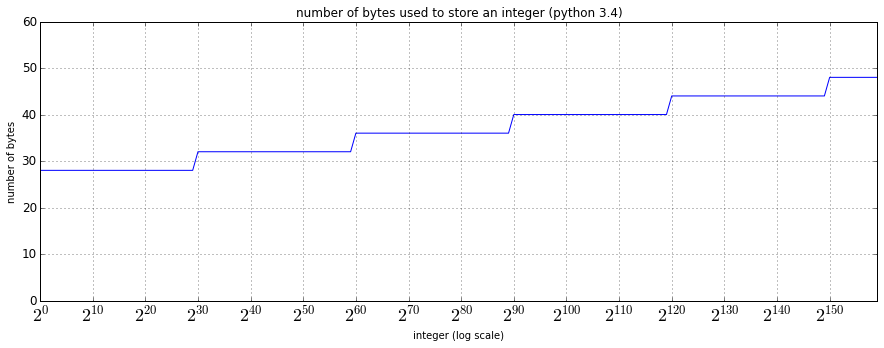

In [6]:
ax = int_sizes.plot(ylim=[0, 60])
ax.set_ylabel('number of bytes')
ax.set_xlabel('integer (log scale)')
ax.set_title('number of bytes used to store an integer (python 3.4)')
ax.set_xticks(range(0, 160, 10))
labels = ['$2^{%d}$' % x for x in range(0, 160, 10)]
ax.set_xticklabels(labels)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=12)

In [7]:
int_sizes[29:31].head()

29    28
30    32
dtype: int64

We can see that it takes 28 bytes before we get to $2^{30}$ where python allocates 4 more bytes to store larger integers. Certainly not the most compact representation, as a raw 64-bit array (i.e. 8 bytes) could do the job with fixed-precision. However we get the benefits of arbitrary precision and many others in python.

Also as we can expect, the storage increases roughly logarithmically as the integer gets larger. And interestly, it looks like python bumps the storage size at $2^{30}$, $2^{60}$, $2^{90}$, and so on. 

## Be Careful with Overflows in numpy

In a lot of situations we would prefer to use the pydata stack (numpy/scipy/pandas) for computation over pure python. It is important to note that overflows can occur, because the data structures under the hood are fixed-precision. Here we have a numpy array of integers

In [8]:
a = np.array([2**63 - 1, 2**63 - 1], dtype=int)
a

array([9223372036854775807, 9223372036854775807])

In [9]:
a.dtype

dtype('int64')

This is a 64-bit integer and therefore $2^{63}-1$ is actually the largest integer it can hold. Adding 1 to the array will *silently* cause an overflow

In [10]:
a + 1

array([-9223372036854775808, -9223372036854775808])

similary, we'd need to be careful with `np.sum`:

In [11]:
a.sum()

-2

On the other hand, `np.mean` actually computes by first converting all inputs into `float`, so the overflow won't happen at this value yet

In [12]:
a.mean()

9.2233720368547758e+18